# Convert netCDF to Zarr format

In [61]:
## import required packages
import numpy as np
import xarray as xr
import s3fs
import zarr
import argparse
from pathlib import Path
import os
import netCDF4 as nc4

In [2]:
sassie_key = 
sassie_secret = 

In [62]:
sassie_s3_netcdf_dir = 's3://podaac-dev-sassie/ECCO_model/N1/V1/HH/NETCDF/'
var_name = 'THETA'
var_name = 'SIarea'

In [63]:
files_to_process = [0,2]

In [64]:
## initialize s3 system for sassie bucket
s3 = s3fs.S3FileSystem(anon=False, key=sassie_key, secret=sassie_secret) 

## list all files
nc_file_list = np.sort(s3.glob(f'{sassie_s3_netcdf_dir}{var_name}_AVG_DAILY/*.nc'))

In [65]:
## append "s3://" to create url in order to open the dataset
nc_file_list_urls = []
for file in nc_file_list:
    file_url_tmp = f"s3://{file}"
    nc_file_list_urls.append(file_url_tmp)

In [66]:
nc_file_list_urls[0:4]

['s3://podaac-dev-sassie/ECCO_model/N1/V1/HH/NETCDF/SIarea_AVG_DAILY/SIarea_day_mean_2014-01-15_ECCO_SASSIE_V1_HH_llc1080.nc',
 's3://podaac-dev-sassie/ECCO_model/N1/V1/HH/NETCDF/SIarea_AVG_DAILY/SIarea_day_mean_2014-01-16_ECCO_SASSIE_V1_HH_llc1080.nc',
 's3://podaac-dev-sassie/ECCO_model/N1/V1/HH/NETCDF/SIarea_AVG_DAILY/SIarea_day_mean_2014-01-17_ECCO_SASSIE_V1_HH_llc1080.nc',
 's3://podaac-dev-sassie/ECCO_model/N1/V1/HH/NETCDF/SIarea_AVG_DAILY/SIarea_day_mean_2014-01-18_ECCO_SASSIE_V1_HH_llc1080.nc']

In [67]:
## specify start and end indices or process all files   
if len(files_to_process) == 2: # two numbers indicates a range (two indices)
    data_urls_select = nc_file_list_urls[files_to_process[0]:files_to_process[1]]
    print(f'... first file to process : {data_urls_select[0]}')
    print(f'... last file to process  : {data_urls_select[-1]}')

elif len(files_to_process) == 1 and files_to_process[0] == -1: # process all files
    data_urls_select = nc_file_list_urls
    print(f'... first file to process : {data_urls_select[0]}')
    print(f'... last file to process  : {data_urls_select[-1]}')

elif len(files_to_process) == 1 and files_to_process[0] >= 0: # process one file using number as index
    # wrap in list
    data_urls_select = [nc_file_list_urls[files_to_process[0]]]
    print(f'... 1 file to process : {data_urls_select}')

else:
    print("ERROR: invalid entry for `files_to_process` argument")

... first file to process : s3://podaac-dev-sassie/ECCO_model/N1/V1/HH/NETCDF/SIarea_AVG_DAILY/SIarea_day_mean_2014-01-15_ECCO_SASSIE_V1_HH_llc1080.nc
... last file to process  : s3://podaac-dev-sassie/ECCO_model/N1/V1/HH/NETCDF/SIarea_AVG_DAILY/SIarea_day_mean_2014-01-16_ECCO_SASSIE_V1_HH_llc1080.nc


In [68]:
data_urls_select

['s3://podaac-dev-sassie/ECCO_model/N1/V1/HH/NETCDF/SIarea_AVG_DAILY/SIarea_day_mean_2014-01-15_ECCO_SASSIE_V1_HH_llc1080.nc',
 's3://podaac-dev-sassie/ECCO_model/N1/V1/HH/NETCDF/SIarea_AVG_DAILY/SIarea_day_mean_2014-01-16_ECCO_SASSIE_V1_HH_llc1080.nc']

In [73]:
def create_encoding(ecco_ds, output_array_precision = np.float32):
    
    # Create NetCDF encoding directives
    # ---------------------------------------------
    # print('\n... creating variable encodings')
    # ... data variable encoding directives
    
    # Define fill values for NaN
    if output_array_precision == np.float32:
        netcdf_fill_value = nc4.default_fillvals['f4']

    elif output_array_precision == np.float64:
        netcdf_fill_value = nc4.default_fillvals['f8']
    
    dv_encoding = dict()
    for dv in ecco_ds.data_vars:
        dv_encoding[dv] =  {'compressor': zarr.Blosc(cname="zlib", clevel=5, shuffle=False)}

    # ... coordinate encoding directives
    coord_encoding = dict()
    
    for coord in ecco_ds.coords:
        # set default no fill value for coordinate
        if output_array_precision == np.float32:
            coord_encoding[coord] = {'_FillValue':None, 'dtype':'float32'}
        elif output_array_precision == np.float64:
            coord_encoding[coord] = {'_FillValue':None, 'dtype':'float64'}

        # force 64 bit ints to be 32 bit ints
        if (ecco_ds[coord].values.dtype == np.int32) or \
           (ecco_ds[coord].values.dtype == np.int64) :
            coord_encoding[coord]['dtype'] ='int32'

        # fix encoding of time
        if coord == 'time' or coord == 'time_bnds':
            coord_encoding[coord]['dtype'] ='int32'

            if 'units' in ecco_ds[coord].attrs:
                # apply units as encoding for time
                coord_encoding[coord]['units'] = ecco_ds[coord].attrs['units']
                # delete from the attributes list
                del ecco_ds[coord].attrs['units']

        elif coord == 'time_step':
            coord_encoding[coord]['dtype'] ='int32'

    # ... combined data variable and coordinate encoding directives
    encoding = {**dv_encoding, **coord_encoding}

    return encoding

### Test to save zarr store on local ec2 instance:

In [77]:
## loop through each file and save new zarr format
for i in range(len(data_urls_select)):
    file_url = data_urls_select[i]
    
    print(f"\n... opening {file_url}")
    s3_file = s3.open(file_url)
    s3_file_ec2 = xr.open_dataset(s3_file)
    s3_file_ec2.close()

    ## create encoding for saving file
    enc = create_encoding(s3_file_ec2)

    filename_i = file_url.split("/")[-1]
    
    ## write the first netCDF to establish the zarr store, then we will append to that one
    if i == 0:
        s3_file_ec2.to_zarr('tmp.zarr', mode='w', encoding=enc)
        print(f"\n... saved first timestep {filename_i} to ec2")
        
    if i > 0:
        ## append with remaining netCDFs
        s3_file_ec2.to_zarr('tmp.zarr', mode='a', consolidated=True, append_dim='time')
        print(f"\n... saved timestep {filename_i} to ec2")


... opening s3://podaac-dev-sassie/ECCO_model/N1/V1/HH/NETCDF/SIarea_AVG_DAILY/SIarea_day_mean_2014-01-15_ECCO_SASSIE_V1_HH_llc1080.nc

... saved first timestep SIarea_day_mean_2014-01-15_ECCO_SASSIE_V1_HH_llc1080.nc to ec2

... opening s3://podaac-dev-sassie/ECCO_model/N1/V1/HH/NETCDF/SIarea_AVG_DAILY/SIarea_day_mean_2014-01-16_ECCO_SASSIE_V1_HH_llc1080.nc

... saved timestep SIarea_day_mean_2014-01-16_ECCO_SASSIE_V1_HH_llc1080.nc to ec2


In [78]:
## open zarr
tmp = xr.open_zarr('tmp.zarr')

In [79]:
tmp.time_bnds.values

array([['2014-01-15T00:00:00.000000000', '2014-01-16T00:00:00.000000000'],
       ['2014-01-16T00:00:00.000000000', '2014-01-17T00:00:00.000000000']],
      dtype='datetime64[ns]')

In [81]:
tmp.SIarea.encoding

{'chunks': (1, 135, 450),
 'preferred_chunks': {'time': 1, 'j': 135, 'i': 450},
 'compressor': Blosc(cname='zlib', clevel=5, shuffle=NOSHUFFLE, blocksize=0),
 'filters': None,
 '_FillValue': nan,
 'dtype': dtype('float64'),
 'coordinates': 'XC YC'}

In [86]:
tmp.close()

### Test to see what happens when I append netCDFs in a different order

First add index 10:12

In [84]:
files_to_process = [10,12]

In [85]:
## specify start and end indices or process all files   
if len(files_to_process) == 2: # two numbers indicates a range (two indices)
    data_urls_select = nc_file_list_urls[files_to_process[0]:files_to_process[1]]
    print(f'... first file to process : {data_urls_select[0]}')
    print(f'... last file to process  : {data_urls_select[-1]}')

elif len(files_to_process) == 1 and files_to_process[0] == -1: # process all files
    data_urls_select = nc_file_list_urls
    print(f'... first file to process : {data_urls_select[0]}')
    print(f'... last file to process  : {data_urls_select[-1]}')

elif len(files_to_process) == 1 and files_to_process[0] >= 0: # process one file using number as index
    # wrap in list
    data_urls_select = [nc_file_list_urls[files_to_process[0]]]
    print(f'... 1 file to process : {data_urls_select}')

else:
    print("ERROR: invalid entry for `files_to_process` argument")

... first file to process : s3://podaac-dev-sassie/ECCO_model/N1/V1/HH/NETCDF/SIarea_AVG_DAILY/SIarea_day_mean_2014-01-25_ECCO_SASSIE_V1_HH_llc1080.nc
... last file to process  : s3://podaac-dev-sassie/ECCO_model/N1/V1/HH/NETCDF/SIarea_AVG_DAILY/SIarea_day_mean_2014-01-26_ECCO_SASSIE_V1_HH_llc1080.nc


In [87]:
## loop through each file and save new zarr format
for i in range(len(data_urls_select)):
    file_url = data_urls_select[i]
    
    print(f"\n... opening {file_url}")
    s3_file = s3.open(file_url)
    s3_file_ec2 = xr.open_dataset(s3_file)
    s3_file_ec2.close()

    filename_i = file_url.split("/")[-1]
    
    ## append netCDFs
    s3_file_ec2.to_zarr('tmp.zarr', mode='a', consolidated=True, append_dim='time')
    print(f"\n... saved timestep {filename_i} to zarr store on ec2")


... opening s3://podaac-dev-sassie/ECCO_model/N1/V1/HH/NETCDF/SIarea_AVG_DAILY/SIarea_day_mean_2014-01-25_ECCO_SASSIE_V1_HH_llc1080.nc

... saved timestep SIarea_day_mean_2014-01-25_ECCO_SASSIE_V1_HH_llc1080.nc to zarr store on ec2

... opening s3://podaac-dev-sassie/ECCO_model/N1/V1/HH/NETCDF/SIarea_AVG_DAILY/SIarea_day_mean_2014-01-26_ECCO_SASSIE_V1_HH_llc1080.nc

... saved timestep SIarea_day_mean_2014-01-26_ECCO_SASSIE_V1_HH_llc1080.nc to zarr store on ec2


In [88]:
## open zarr
tmp = xr.open_zarr('tmp.zarr')

In [90]:
tmp.time.values

array(['2014-01-15T12:00:00.000000000', '2014-01-16T12:00:00.000000000',
       '2014-01-25T12:00:00.000000000', '2014-01-26T12:00:00.000000000'],
      dtype='datetime64[ns]')

In [89]:
tmp.time_bnds.values

array([['2014-01-15T00:00:00.000000000', '2014-01-16T00:00:00.000000000'],
       ['2014-01-16T00:00:00.000000000', '2014-01-17T00:00:00.000000000'],
       ['2014-01-25T00:00:00.000000000', '2014-01-26T00:00:00.000000000'],
       ['2014-01-26T00:00:00.000000000', '2014-01-27T00:00:00.000000000']],
      dtype='datetime64[ns]')

In [91]:
tmp.SIarea.encoding

{'chunks': (1, 135, 450),
 'preferred_chunks': {'time': 1, 'j': 135, 'i': 450},
 'compressor': Blosc(cname='zlib', clevel=5, shuffle=NOSHUFFLE, blocksize=0),
 'filters': None,
 '_FillValue': nan,
 'dtype': dtype('float64'),
 'coordinates': 'XC YC'}

In [92]:
tmp.close()

Then add index 5:7

In [93]:
files_to_process = [5,7]

In [94]:
## specify start and end indices or process all files   
if len(files_to_process) == 2: # two numbers indicates a range (two indices)
    data_urls_select = nc_file_list_urls[files_to_process[0]:files_to_process[1]]
    print(f'... first file to process : {data_urls_select[0]}')
    print(f'... last file to process  : {data_urls_select[-1]}')

elif len(files_to_process) == 1 and files_to_process[0] == -1: # process all files
    data_urls_select = nc_file_list_urls
    print(f'... first file to process : {data_urls_select[0]}')
    print(f'... last file to process  : {data_urls_select[-1]}')

elif len(files_to_process) == 1 and files_to_process[0] >= 0: # process one file using number as index
    # wrap in list
    data_urls_select = [nc_file_list_urls[files_to_process[0]]]
    print(f'... 1 file to process : {data_urls_select}')

else:
    print("ERROR: invalid entry for `files_to_process` argument")

... first file to process : s3://podaac-dev-sassie/ECCO_model/N1/V1/HH/NETCDF/SIarea_AVG_DAILY/SIarea_day_mean_2014-01-20_ECCO_SASSIE_V1_HH_llc1080.nc
... last file to process  : s3://podaac-dev-sassie/ECCO_model/N1/V1/HH/NETCDF/SIarea_AVG_DAILY/SIarea_day_mean_2014-01-21_ECCO_SASSIE_V1_HH_llc1080.nc


In [95]:
## loop through each file and save new zarr format
for i in range(len(data_urls_select)):
    file_url = data_urls_select[i]
    
    print(f"\n... opening {file_url}")
    s3_file = s3.open(file_url)
    s3_file_ec2 = xr.open_dataset(s3_file)
    s3_file_ec2.close()

    filename_i = file_url.split("/")[-1]
    
    ## append netCDFs
    s3_file_ec2.to_zarr('tmp.zarr', mode='a', consolidated=True, append_dim='time')
    print(f"\n... saved timestep {filename_i} to zarr store on ec2")


... opening s3://podaac-dev-sassie/ECCO_model/N1/V1/HH/NETCDF/SIarea_AVG_DAILY/SIarea_day_mean_2014-01-20_ECCO_SASSIE_V1_HH_llc1080.nc

... saved timestep SIarea_day_mean_2014-01-20_ECCO_SASSIE_V1_HH_llc1080.nc to zarr store on ec2

... opening s3://podaac-dev-sassie/ECCO_model/N1/V1/HH/NETCDF/SIarea_AVG_DAILY/SIarea_day_mean_2014-01-21_ECCO_SASSIE_V1_HH_llc1080.nc

... saved timestep SIarea_day_mean_2014-01-21_ECCO_SASSIE_V1_HH_llc1080.nc to zarr store on ec2


In [96]:
## open zarr
tmp = xr.open_zarr('tmp.zarr')

In [97]:
tmp.time.values

array(['2014-01-15T12:00:00.000000000', '2014-01-16T12:00:00.000000000',
       '2014-01-25T12:00:00.000000000', '2014-01-26T12:00:00.000000000',
       '2014-01-20T12:00:00.000000000', '2014-01-21T12:00:00.000000000'],
      dtype='datetime64[ns]')

In [98]:
tmp.time_bnds.values

array([['2014-01-15T00:00:00.000000000', '2014-01-16T00:00:00.000000000'],
       ['2014-01-16T00:00:00.000000000', '2014-01-17T00:00:00.000000000'],
       ['2014-01-25T00:00:00.000000000', '2014-01-26T00:00:00.000000000'],
       ['2014-01-26T00:00:00.000000000', '2014-01-27T00:00:00.000000000'],
       ['2014-01-20T00:00:00.000000000', '2014-01-21T00:00:00.000000000'],
       ['2014-01-21T00:00:00.000000000', '2014-01-22T00:00:00.000000000']],
      dtype='datetime64[ns]')

In [91]:
tmp.SIarea.encoding

{'chunks': (1, 135, 450),
 'preferred_chunks': {'time': 1, 'j': 135, 'i': 450},
 'compressor': Blosc(cname='zlib', clevel=5, shuffle=NOSHUFFLE, blocksize=0),
 'filters': None,
 '_FillValue': nan,
 'dtype': dtype('float64'),
 'coordinates': 'XC YC'}

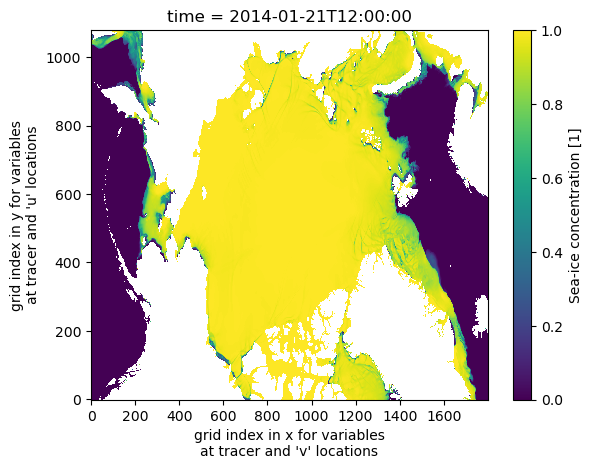

In [114]:
tmp.isel(time=-1).SIarea.plot()

In [92]:
tmp.close()

#### can append in different order and then just sortby the date

In [102]:
tmp_sorted = tmp.sortby("time")

In [104]:
## create encoding for saving file
enc = create_encoding(tmp_sorted)

## write new zarr store with time sorted
tmp_sorted.to_zarr('tmp_time_sorted.zarr', mode='w')

In [105]:
## open zarr
tmp_time_sorted = xr.open_zarr('tmp_time_sorted.zarr')

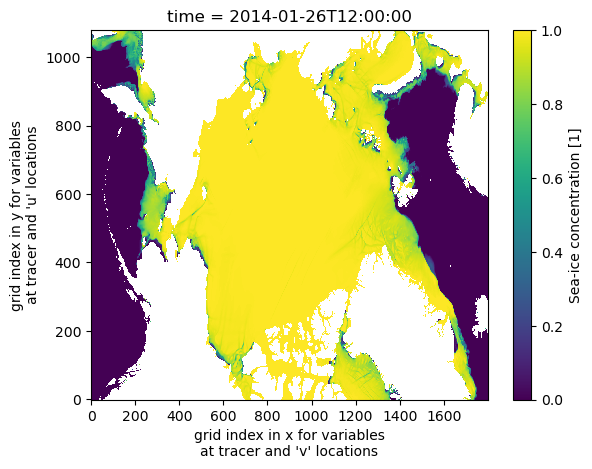

In [113]:
tmp_time_sorted.isel(time=-1).SIarea.plot()

In [110]:
tmp_time_sorted.SIarea.encoding

{'chunks': (1, 135, 450),
 'preferred_chunks': {'time': 1, 'j': 135, 'i': 450},
 'compressor': Blosc(cname='zlib', clevel=5, shuffle=NOSHUFFLE, blocksize=0),
 'filters': None,
 '_FillValue': nan,
 'dtype': dtype('float64'),
 'coordinates': 'XC YC'}

### On the cloud

In [3]:
sassie_s3_netcdf_dir = 's3://podaac-dev-sassie/ECCO_model/N1/V1/HH/NETCDF/'
var_name = 'THETA'
var_name = 'SIarea'

In [40]:
files_to_process = [0,3]

In [41]:
## initialize s3 system for sassie bucket
s3 = s3fs.S3FileSystem(anon=False, key=sassie_key, secret=sassie_secret) 

## list all files
nc_file_list = np.sort(s3.glob(f'{sassie_s3_netcdf_dir}{var_name}_AVG_DAILY/*.nc'))

In [42]:
## append "s3://" to create url in order to open the dataset
nc_file_list_urls = []
for file in nc_file_list:
    file_url_tmp = f"s3://{file}"
    nc_file_list_urls.append(file_url_tmp)

In [43]:
nc_file_list_urls[0:4]

['s3://podaac-dev-sassie/ECCO_model/N1/V1/HH/NETCDF/SIarea_AVG_DAILY/SIarea_day_mean_2014-01-15_ECCO_SASSIE_V1_HH_llc1080.nc',
 's3://podaac-dev-sassie/ECCO_model/N1/V1/HH/NETCDF/SIarea_AVG_DAILY/SIarea_day_mean_2014-01-16_ECCO_SASSIE_V1_HH_llc1080.nc',
 's3://podaac-dev-sassie/ECCO_model/N1/V1/HH/NETCDF/SIarea_AVG_DAILY/SIarea_day_mean_2014-01-17_ECCO_SASSIE_V1_HH_llc1080.nc',
 's3://podaac-dev-sassie/ECCO_model/N1/V1/HH/NETCDF/SIarea_AVG_DAILY/SIarea_day_mean_2014-01-18_ECCO_SASSIE_V1_HH_llc1080.nc']

In [58]:
## define s3 zarr bucket directory
zarr_s3_bucket_dir = f"s3://podaac-dev-sassie/ECCO_model/N1/V1/HH/ZARR/{var_name}_AVG_DAILY.ZARR/"
s3_store = s3fs.S3Map(root=zarr_s3_bucket_dir, s3=s3, check=False)

## loop through each file and save new zarr format
for i in range(len(data_urls_select)):
    file_url = data_urls_select[i]
    
    print(f"\n... opening {file_url}")
    s3_file = s3.open(file_url)
    s3_file_ec2 = xr.open_dataset(s3_file)
    s3_file_ec2.close()

    ## get filename
    filename_i = file_url.split("/")[-1]

    ## write the first netCDF to establish the zarr store, then we will append to that one
    if i == 0:
        s3_file_ec2.to_zarr(store=s3_store, mode='w')
        print(f"\n... saved first timestep {filename_i} to {zarr_s3_bucket_dir}")
    if i > 0:
        ## append with remaining netCDFs
        s3_file_ec2.to_zarr(store=s3_store, mode='a', consolidated=True, append_dim='time')
        print(f"\n... saved first timestep {filename_i} to {zarr_s3_bucket_dir}")
    
    print(f"* * * * * saved all netCDF files to zarr store: {zarr_s3_bucket_dir} * * * * *")


... opening s3://podaac-dev-sassie/ECCO_model/N1/V1/HH/NETCDF/SIarea_AVG_DAILY/SIarea_day_mean_2014-01-15_ECCO_SASSIE_V1_HH_llc1080.nc

... opening s3://podaac-dev-sassie/ECCO_model/N1/V1/HH/NETCDF/SIarea_AVG_DAILY/SIarea_day_mean_2014-01-16_ECCO_SASSIE_V1_HH_llc1080.nc

... opening s3://podaac-dev-sassie/ECCO_model/N1/V1/HH/NETCDF/SIarea_AVG_DAILY/SIarea_day_mean_2014-01-17_ECCO_SASSIE_V1_HH_llc1080.nc
